# What's Cooking Multinomial Classification Challenge
![](images/cuisine.png)

![](images/fr.png) ![](images/us.png) ![](images/kr.png) ![](images/it.png) ![](images/in.png) ![](images/jp.png) ![](images/ru.png) ![](images/th.png) ![](images/es.png) ![](images/gr.png) ![](images/mx.png) ![](images/jm.png) ![](images/cn.png) ![](images/vn.png)

Categorize list of ingredients into cuisine types (20 labels).

https://www.kaggle.com/c/whats-cooking


In [1]:
# Main configuration parameters
dryRun = False

if dryRun:
    nbPCAComponents = 2
    n_folds = 2
    early_stopping = 1
    maxIterations = 1
else:
    nbPCAComponents = 300
    n_folds = 4
    early_stopping = 10
    maxIterations = 200

# Explore data
<img src="images/explore.png" width="100">

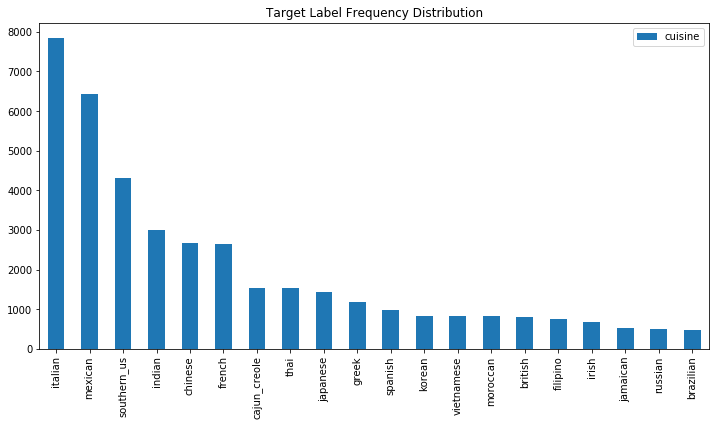

In [2]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
rawTrain = pd.read_json('data/train.json')
rawTrain = rawTrain.drop(['id'], axis=1)
if dryRun:
    rawTrain = rawTrain.sample(5000)
    
pd.DataFrame(pd.Series(rawTrain.cuisine).value_counts()).plot.bar(figsize=(12,6), title='Target Label Frequency Distribution')
pass

## Clean ingredient texts
<img src="images/broom.png" width="150">

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I051796\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\I051796\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\I051796\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# data cleansing
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

stopWords = set(stopwords.words('english'))

# JJ: adjective
stopTypes = ['JJ', 'POS','UH','PRP' ,'DT', 'CC']

showDiff = True
showStopFreqWords = False
showStopTypeWords = True
showCount = 0
maxShowCount = 10


def cleanIngredients(ingredients):
    cleanIngredients = list()
    for ingredient in ingredients:
        cleanIngredient = ingredient.lower()
        # remove special characters (only alphabets are kept)
        cleanIngredient = re.sub(r"[^a-zA-Z\sçàéè\-î]+", '', cleanIngredient)
        # remove usless spaces
        cleanIngredient = re.sub(r"\s{2,}", ' ', cleanIngredient)
        cleanIngredient = re.sub(r"^\s", '', cleanIngredient)
        cleanIngredient = re.sub(r"\s$", '', cleanIngredient)
        # remove usual stop words
        words = word_tokenize(cleanIngredient)
        stopFreqWords = [word for word in words if word not in stopWords]
        if showStopFreqWords and len(stopFreqWords) != len(words):
            print("{} -> {}".format(words, stopFreqWords))
        
        # remove adjective (qualification) => currently disable
        if False:
            words = nltk.pos_tag(stopFreqWords)
            stopTypeWords = [w for w, wtype in words if wtype not in stopTypes]            
            if showStopTypeWords and len(stopTypeWords) != len(stopFreqWords):
                print("{} -> {}".format(stopFreqWords, stopTypeWords)) 
        else:
            stopTypeWords = stopFreqWords
            
        cleanIngredient = " ".join(stopTypeWords)
        # final final difference if any
        global showCount
        if showDiff and showCount < maxShowCount and cleanIngredient != ingredient:
            showCount = showCount + 1
            print("{} -> {}".format(ingredient, cleanIngredient))
            if showCount == maxShowCount:
                print("....")
        
        cleanIngredients.append(cleanIngredient)
    return cleanIngredients  

print("Cleaning ingredient texts...\n")
%time rawTrain['cleanIngredients'] = rawTrain.ingredients.map(lambda x: cleanIngredients(x))

Cleaning ingredient texts...

Shaoxing wine -> shaoxing wine
Italian parsley leaves -> italian parsley leaves
sweet and sour sauce -> sweet sour sauce
Johnsonville Andouille Dinner Sausage -> johnsonville andouille dinner sausage
Oscar Mayer Deli Fresh Smoked Ham -> oscar mayer deli fresh smoked ham
1% low-fat milk -> low-fat milk
Gochujang base -> gochujang base
Taiwanese bok choy -> taiwanese bok choy
pumpkin purÃ©e -> pumpkin pure
Sriracha -> sriracha
....
Wall time: 53.5 s


In [5]:
# switch to clean ingredients
rawTrain.ingredients = rawTrain.cleanIngredients
rawTrain = rawTrain.drop(columns=['cleanIngredients'])

## Examine ingredients
<img src="images/food2.png" width="150">

In [6]:
# build distinct ingredient names from training
uniqueTrainIngredients = set()
for i,v in rawTrain.ingredients.iteritems():
    uniqueTrainIngredients.update(v)
uniqueTrainIngredients = list(uniqueTrainIngredients)

print("number of distinct ingredients = {}".format(len(uniqueTrainIngredients)))
pd.Series(uniqueTrainIngredients).to_csv("ingredients.csv", index=None)
pd.DataFrame(uniqueTrainIngredients, columns=['ingredient']).sample(5)

number of distinct ingredients = 6684


,ingredient
338,hot chili paste
5926,cooking apples
4680,mazola canola oil
4284,peppadews
3300,nonfat greek yogurt


In [7]:
# build distinct words from ingredient names
trainVocabularies = list()
for ingredient in uniqueTrainIngredients:
    trainVocabularies.append(ingredient.split(" "))
# flatten list of lists
trainVocabularies = pd.DataFrame([item for sublist in trainVocabularies for item in sublist], columns=['word'])
trainVocabularies['count'] = 1
hist = trainVocabularies.groupby(by=['word']).count()
hist.sort_values('count', ascending=False).head(10)

,count
word,
cheese,200
sauce,196
chicken,190
mix,121
cream,115
rice,109
sodium,107
fresh,100
dried,97


# Prepare data
<img src="images/pan.png" width="150">

In [8]:
rawTrain["set"] = rawTrain.ingredients.apply(lambda x: set(x))
print("Vectorizing dataset...\n")

from tqdm import tqdm
for ingr in tqdm(uniqueTrainIngredients):
    rawTrain[ingr] = rawTrain.set.apply(lambda x: 1 if ingr in x else 0)

Vectorizing dataset...



100%|██████████| 6684/6684 [04:22<00:00, 25.47it/s]


In [9]:
#rawTrain.to_csv('/Users/i051796/projects/Challenge/vector.csv')
#rawTrain = pd.read_csv('/Users/i051796/projects/Challenge/vector.csv')

In [10]:
# apply TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
features = rawTrain.drop(columns=['cuisine', 'set','ingredients'])
tfIdf = TfidfTransformer()
print("Applying TF-DIF transform...\n")
%time rescaledFeatures = tfIdf.fit_transform(features)

rescaledFeatures= pd.DataFrame(rescaledFeatures.toarray())

Applying TF-DIF transform...

Wall time: 24.5 s


In [11]:
# apply a PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=nbPCAComponents)
print("Applying PCA transform from {} to {} dimension...\n".format(len(uniqueTrainIngredients), nbPCAComponents))
%time pcaFeatures = pca.fit_transform(rescaledFeatures)

Applying PCA transform from 6684 to 300 dimension...

Wall time: 30.1 s


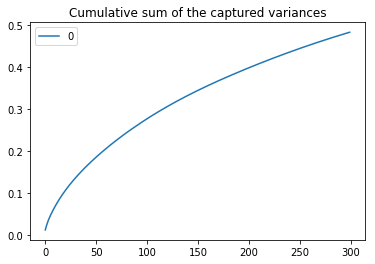

In [12]:
pd.DataFrame(pca.explained_variance_ratio_.cumsum()).plot(title='Cumulative sum of the captured variances')

In [13]:
rawTrain['countIngr'] = rawTrain.ingredients.map(lambda x : len(x))

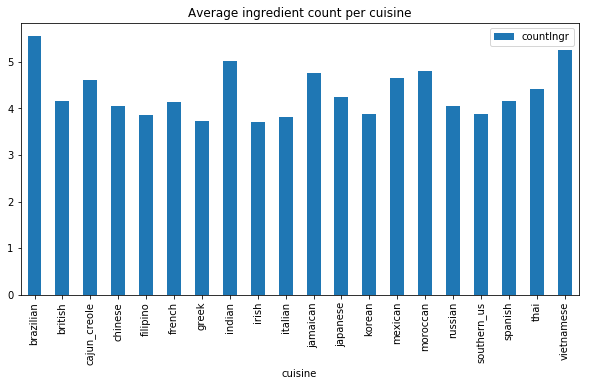

In [14]:
rawTrain[['countIngr','cuisine']].groupby(by='cuisine').std().plot(title="Average ingredient count per cuisine", figsize=(10,5), kind='bar')

In [15]:
rawTrain['weight'] = rawTrain.cuisine.map(lambda x: 2. if x == 'italian' else 1.)
#pcaFeatures = pcaFeatures.drop(columns=['weight'])

# Learn from data
<div style="vertical-align:middle">
    <img src="images/learn.png" width="150" >
    <img src="images/xgb.png" width="200">
</divs>

In [16]:
import xgboost as xgb

pcaFeatures = pd.DataFrame(pcaFeatures)

from sklearn import preprocessing
labelEncoder = preprocessing.LabelEncoder()
y = labelEncoder.fit_transform(rawTrain.cuisine)

## Optimize parameters
<img src="images/optim.png" width="100">

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

print("Optimizing XGBoost parameters...\n")

classifier = xgb.XGBClassifier(
    early_stopping_rounds = early_stopping,
    n_estimators= maxIterations,
    nthread=6,
    objective= 'multi:softprob',
    silent=False
)

params = {
    'learning_rate': [.02,.05,.1],
    'colsample_bytree': [0.6,1.0],
    'max_depth': [3,5,8]
}

skf = StratifiedKFold(
    n_splits=n_folds,
    shuffle = True,
    random_state = 1960)

randomSearch = RandomizedSearchCV(
    classifier,
    param_distributions=params,
    n_iter=8,
    scoring='accuracy',
    n_jobs=5,
    cv=skf.split(pcaFeatures,y),
    verbose=2,
    random_state=1960
)

%time randomSearch.fit(pcaFeatures, y)
print("\nBest average accuracy on validation fold = {}\n".format(max(randomSearch.cv_results_['mean_test_score'])))

## Build final model
<img src="images/build.png" width="120">

In [ ]:
import xgboost as xgb

print("Fitting the final XGBoost model...\n")

classifier = xgb.XGBClassifier(
    learning_rate= randomSearch.best_params_['learning_rate'],
    colsample_bytree= randomSearch.best_params_['colsample_bytree'],
    max_depth= randomSearch.best_params_['max_depth'],
    early_stopping_rounds = early_stopping,
    n_estimators= maxIterations,
    nthread=10,
    objective= 'multi:softprob',
    silent=False
)

#classifier.fit(pcaFeatures, y=y, verbose=True, sample_weight = rawTrain['weight'].tolist())
%time classifier.fit(pcaFeatures, y=y, verbose=True)
classifier

In [19]:
import pickle
#pickle.dump(classifier, open("xgboost_model.dat", "wb"))
#classifier = pickle.load(open("xgboost_model.dat", "rb"))

# Measure performance
<img src="images/perf.png" width="170">

In [20]:
print("Applying the model to the training dataset...\n")
%time yDecision = classifier.predict(pcaFeatures)

Applying the model to the training dataset...

Wall time: 3.71 s


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      1.00      1.00       804
           2       1.00      1.00      1.00      1546
           3       1.00      1.00      1.00      2673
           4       1.00      1.00      1.00       755
           5       1.00      1.00      1.00      2646
           6       1.00      1.00      1.00      1175
           7       1.00      1.00      1.00      3003
           8       1.00      1.00      1.00       667
           9       1.00      1.00      1.00      7838
          10       1.00      1.00      1.00       526
          11       1.00      1.00      1.00      1423
          12       1.00      1.00      1.00       830
          13       1.00      1.00      1.00      6438
          14       1.00      1.00      1.00       821
          15       1.00      1.00      1.00       489
          16       1.00      1.00      1.00      4320
          17       1.00    

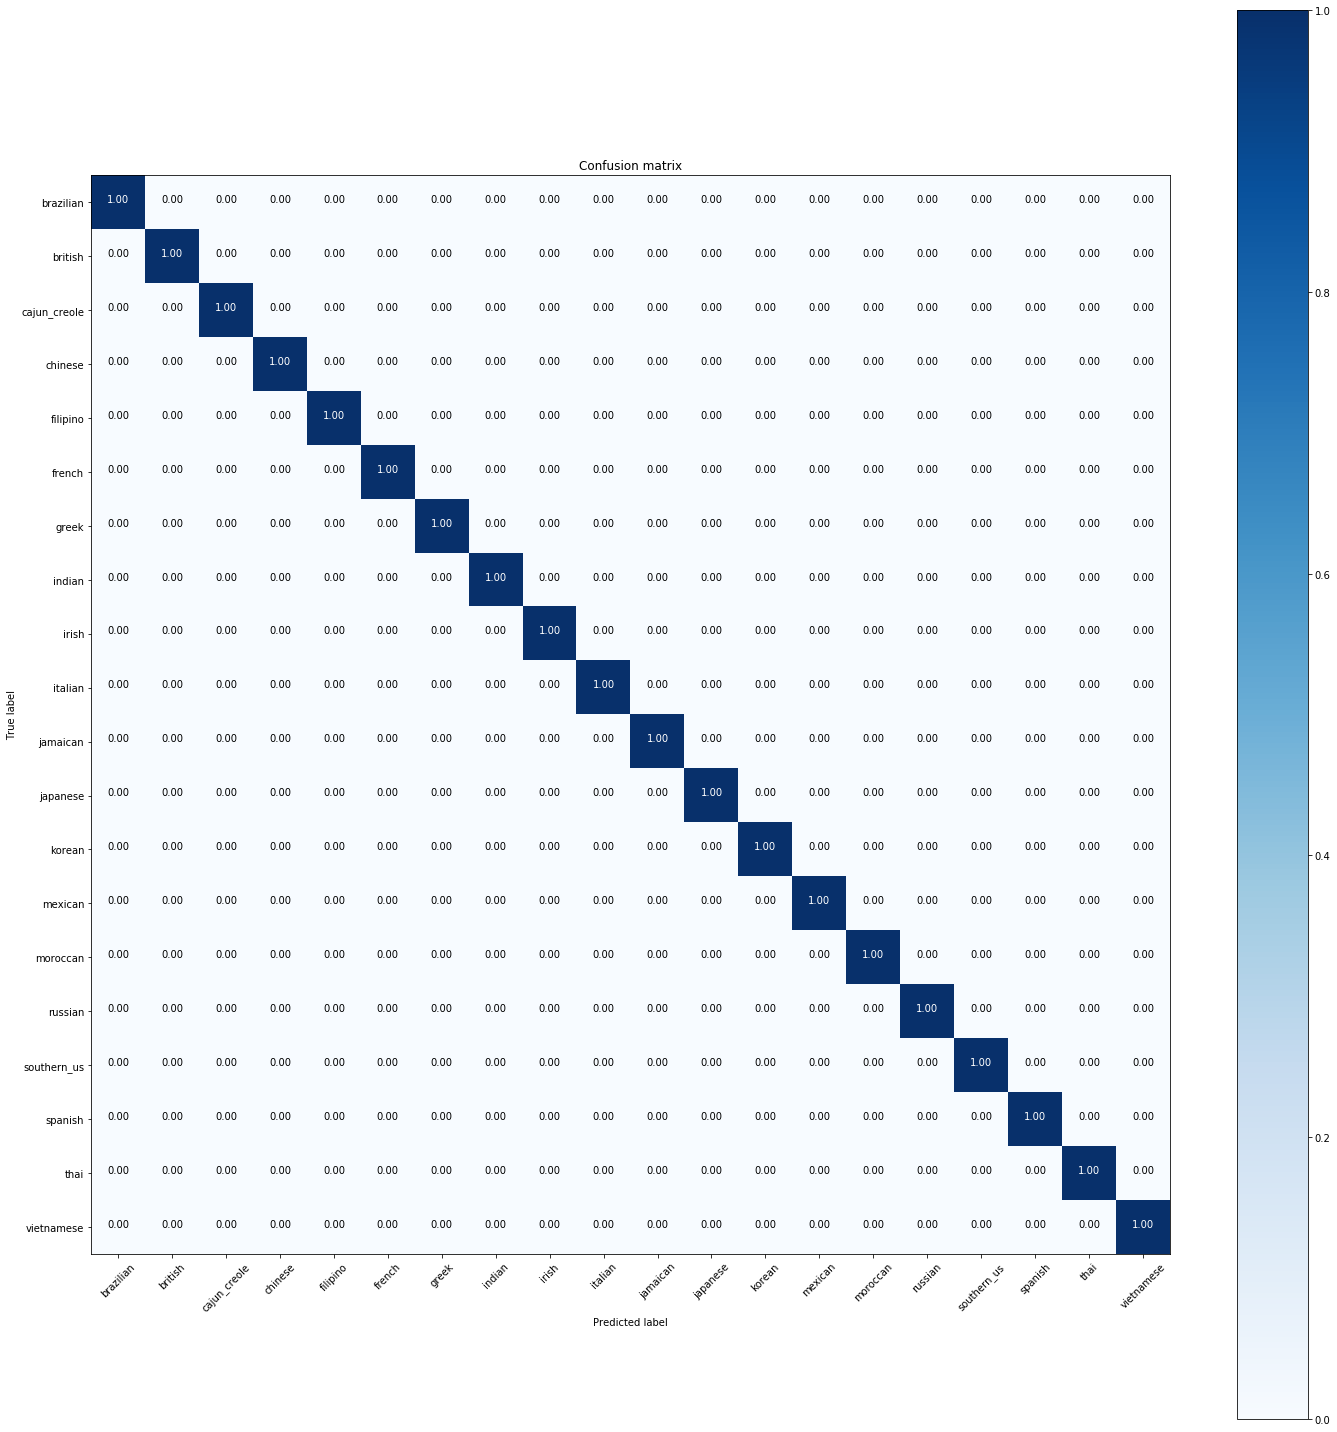

In [22]:
from sklearn.metrics import confusion_matrix
import sklearn

cnf_matrix = confusion_matrix(y.tolist(), yDecision.tolist())

print(sklearn.metrics.classification_report(y, yDecision))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=True, classes = labelEncoder.classes_)

plt.show()


In [23]:
import numpy as np

# define the pipeline to prepare the data for simulate/apply
# return a data frame with a single row
def prepareDataForApply(ingredientSet):
    # vectorize
    row = list()
    for ingr in uniqueTrainIngredients:
        row.append(1if ingr in ingredientSet else 0)
    result = pd.DataFrame([row], columns=uniqueTrainIngredients) 
    # apply tf-idf
    result = tfIdf.transform(result)
    # apply pca
    result = pca.transform(result.toarray())
    result = pd.DataFrame(result)
    #result.rename(axis='columns', inplace=True, mapper=lambda x: "f" + str(x))
    return result

# Open Your Fridge

<img src="images/fridge.png" width="150">

Tell me what you have in your fridge, i will tell you if the mixture is eatable !

In [24]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, IntSlider

sortedUniqueTrainIngredients = sorted(uniqueTrainIngredients)
ingrWidget1 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 1',
    disabled=False
)

ingrWidget2 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 2',
    disabled=False
)

ingrWidget3 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 3',
    disabled=False
)

ingrWidget4 = widgets.Dropdown(
    options=sortedUniqueTrainIngredients,
    description='ingredient 4',
    disabled=False
)

button = widgets.Button(
    description='Indigestion?',
    disabled=False,
    tooltip='Estimate Indigestion Level'
)

res = widgets.HTML(
    value="Hello <b>World</b>",
)

file = open("images/danger.png", "rb")
image = file.read()

danger_image = widgets.Image(
    value=image,
    format='png',
    width=50,
    height=50
)

file = open("images/safe.png", "rb")
image = file.read()
safe_image = widgets.Image(
    value=image,
    format='png',
    width=50,
    height=50
)

countryImages = dict()
countryFileNames = {
'brazilian':'br',
'british':'gb',
'cajun_creole':'us',
'chinese':'cn',
'filipino': 'ph',
'french':'fr',
'greek':'gr',
'indian':'in',
'irish':'ie',
'italian':'it',
'jamaican':'jm',
'japanese':'jp',
'korean':'kr',
'mexican':'mx',
'moroccan':'ma',
'russian': 'ru',
'southern_us': 'us',
'spanish' : 'es',
'thai':'th',
'vietnamese':'vn'
}

for country in labelEncoder.classes_:
    file = open("images/" + countryFileNames[country] + ".png", "rb")
    countryImages[country] = file.read()

country_image = widgets.Image(
    value=countryImages['vietnamese'],
    format='png'
)

country_label = widgets.Label(
)

slider = IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,    
    disable=True)

hbox = HBox([danger_image, slider, safe_image])
hbox2 = HBox([country_image, country_label])

def onChange(change):
    try:
        selectedIngredients = set()
        if len(ingrWidget1.value) > 0:
            selectedIngredients.add(ingrWidget1.value)
        if len(ingrWidget2.value) > 0:
            selectedIngredients.add(ingrWidget2.value)
        if len(ingrWidget3.value) > 0:
            selectedIngredients.add(ingrWidget3.value)
        if len(ingrWidget4.value) > 0:
            selectedIngredients.add(ingrWidget4.value)

        testData = prepareDataForApply(selectedIngredients)

        probas = classifier.predict_proba(testData)
        indexMax = np.argmax(probas)
        maxProba=probas.max()
        mostProbableCountry = labelEncoder.inverse_transform([indexMax])[0] 

        # update widgets
        country_label.value = mostProbableCountry
        country_image.value = countryImages[mostProbableCountry]
        slider.value = np.rint(maxProba * 100.)
    except Exception as es:
        country_label.value = str(e)
    
    return

ingrWidget1.observe(onChange)
ingrWidget2.observe(onChange)
ingrWidget3.observe(onChange)
ingrWidget4.observe(onChange)

display(ingrWidget1)
display(ingrWidget2)
display(ingrWidget3)
display(ingrWidget4)

display(hbox)
display(hbox2)

Dropdown(description='ingredient 1', options=('', 'aai', 'aai powder', 'abalone', 'abbamele', 'absinthe', 'abu…

Dropdown(description='ingredient 2', options=('', 'aai', 'aai powder', 'abalone', 'abbamele', 'absinthe', 'abu…

Dropdown(description='ingredient 3', options=('', 'aai', 'aai powder', 'abalone', 'abbamele', 'absinthe', 'abu…

Dropdown(description='ingredient 4', options=('', 'aai', 'aai powder', 'abalone', 'abbamele', 'absinthe', 'abu…